In [1]:
import torch
import torch.nn as nn
import torch.optim as optm
import os
import json
from metrics_amazon import CM, f1_score0, f1_score1, Recall, Precision, ACC
import numpy as np
from preprocess import load_tif_image, extract_temporal_sorted_patches, extract_sorted_patches, divide_pred_windows
import matplotlib.pyplot as plt

import imageio
import matplotlib.animation as animation
from IPython.display import HTML


/home/thiago/python-envs/base/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [30]:
def display_video(video):
    fig = plt.figure()
    ims = []
    for i in range(video.shape[0]):
        im = plt.imshow(video[i], animated=True)
        ims.append([im])
    ani = animation.ArtistAnimation(fig, ims, interval=50, blit=True, repeat_delay=1000)
    plt.close()
    ani.save('animation.mp4', writer='ffmpeg')
    # return HTML(ani.to_jshtml())
    return HTML(ani.to_html5_video())

In [2]:
experiment = 'custom_exp2'

preds = np.load(os.path.join('work_dirs', experiment, 'preds.npy'))
print(preds.shape)
# preds_reconstructed = np.load(os.path.join('work_dirs', experiment, 'img_reconstructed.npy'))
# def_preds_reconstructed = np.load(os.path.join('work_dirs', experiment, 'def_img_reconstructed.npy'))

mean_std = np.load(os.path.join('work_dirs', experiment, 'mean_std.npy'))

training_config = json.load(open(os.path.join('work_dirs', experiment, 'model_training.json')))
print(training_config)

(79248, 2, 2, 64, 64)
{'pre_seq_length': 4, 'aft_seq_length': 2, 'total_length': 6, 'batch_size': 16, 'val_batch_size': 16, 'epoch': 100, 'lr': 0.0001, 'metrics': ['mse', 'mae'], 'ex_name': 'custom_exp2', 'dataname': 'custom', 'in_shape': [4, 1, 64, 64], 'patience': 10, 'delta': 0.0001, 'amazon_mask': True, 'pixel_size': '1K', 'patch_size': 64, 'window_size': 6, 'overlap': 0.15, 'loss': 'focal', 'aux_metrics': ['f1_score0', 'f1_score1', 'CM'], 'normalize': True}


In [4]:
# Load Test Image
deter_img = load_tif_image('data/DETER/deter_increments_1km_1week.tif')

mask = load_tif_image('data/IBAMA_INPE/1K/tiff_filled/mask.tif')
mask = mask[:deter_img.shape[1], :deter_img.shape[2]]

deter_img[:, mask == 0] = -1
# deter_img[deter_img > 0] = 1
deter_img_test = deter_img[(96 + 48):(96 + 48 + 48)]
del deter_img

In [9]:
print(deter_img_test.shape)

(63, 2333, 3005)


In [33]:
display_video(deter_img_test)

In [29]:
plt.show()
# with open('animation.html', 'w') as f:
#     f.write(str(html_video))

In [4]:
print(deter_img_test.shape)
print(mask.shape)

(48, 2333, 3005)
(2333, 3005)


In [5]:
test_patches = extract_temporal_sorted_patches(deter_img_test, training_config['patch_size'])
print('Test Patches:', test_patches.shape)

mask_test_patches = extract_sorted_patches(mask, training_config['patch_size'])
print('Mask Test Patches:', mask_test_patches.shape)

Test Patches: (48, 1656, 64, 64)
Mask Test Patches: (1656, 64, 64)


In [6]:
test_files, mask_test_files, _ = divide_pred_windows(test_patches, min_def=0, window_size=training_config['total_length'],\
    mask_patches=mask_test_patches)
print(f'Test shape: {test_files.shape} - {mask_test_files.shape}')
del test_patches, mask_test_patches

Dividing in prediction windows:   0%|          | 0/79248 [00:00<?, ?it/s]/home/thiago/python-envs/base/lib/python3.10/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/thiago/python-envs/base/lib/python3.10/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
Dividing in prediction windows: 100%|██████████| 79248/79248 [00:02<00:00, 36293.59it/s]


0 Skipped Images
Test shape: (79248, 6, 64, 64) - (79248, 64, 64)


In [18]:
min_def = 0.001
skip_count = 0
def_indexes = []
def_means = []
for i in range(test_files.shape[0]):
    # print(f'Processing {i} of {test_files.shape[0]}')
    # test_files[i] = (test_files[i] - mean_std[0])/mean_std[1]
    patches = test_files[i]
    labels = patches[-2:]
    _label = labels[:, mask_test_files[i] == 1]
    _label[_label > 0] = 1
    # print(_label.shape)
    mean = np.mean(_label, axis=(0, 1))
    # 1/0
    # Deal with Nan
    if np.isnan(mean): mean = 0
    # if np.isnan(mean[0]): mean[0] = 0
    # if np.isnan(mean[1]): mean[1] = 0
    # if mean[0] < min_def or mean[1] < min_def:
    if mean < min_def:
    # if mean[0] + mean[1] < min_def:
        skip_count += 1
        # print('here')
        continue
    # print(mean.shape)
    # print(mean[0] + mean[1])
    def_indexes.append(i)
    def_means.append(mean)
    # patches_pred = preds[i, 1]
    # patches_pred[:, mask_test_files[i] == 0] = -1
    # patches[:, mask_test_files[i] == 0] = -1
    # print('finished')
    # break
print(f'Skipped {skip_count} patches')

Skipped 79147 patches


In [19]:
print(patches.shape)
# print(patches_pred.shape)
print(len(def_indexes))
print(len(def_means))
print(def_indexes)

(6, 64, 64)
101
101
[36700, 36701, 36705, 36706, 36714, 36715, 36718, 36719, 36760, 36761, 36762, 36846, 36847, 36895, 36896, 37073, 37074, 37081, 37082, 37120, 37121, 37162, 37163, 37170, 37171, 37176, 37177, 37207, 37208, 37303, 37304, 37404, 37405, 37565, 37566, 37671, 37672, 37673, 37674, 37717, 37718, 38174, 38175, 38266, 38398, 38399, 38408, 38412, 38413, 38455, 38456, 38534, 38535, 38541, 38542, 38543, 38577, 38578, 38579, 38580, 38582, 38583, 38585, 38586, 38587, 38588, 38630, 38631, 38632, 38642, 38643, 38674, 38719, 38720, 38721, 38723, 38724, 38725, 38726, 38767, 38768, 38773, 38774, 38776, 38777, 38778, 38820, 38821, 38822, 38823, 38824, 38975, 38976, 39021, 39022, 39061, 39062, 39413, 39414, 39459, 39460]


In [20]:
# sort def_indexes by def_means
def_indexes = np.array(def_indexes)
def_means = np.array(def_means)
def_indexes = def_indexes[np.argsort(def_means)]
print(def_indexes)
print(def_means[np.argsort(def_means)])

[38588 38408 38630 38632 38820 38776 38456 38976 39061 39062 38822 38723
 38674 38543 38266 38175 38174 37208 37566 37565 37405 37404 37207 36700
 36701 37121 37120 36895 36896 39022 38821 38583 38582 39460 38726 38719
 38580 39459 38778 38455 38585 39021 38777 37304 37303 37081 36719 36714
 36718 37082 38631 38975 39413 38577 39414 38541 38399 38587 38535 38398
 38721 37162 36715 36706 37177 36705 37176 37163 38824 38724 38725 38586
 38542 37718 36846 36847 37717 38823 38767 38768 38534 37170 36760 37171
 38720 38412 38413 38643 38642 37671 37672 37673 37674 37073 37074 38579
 38774 38578 38773 36762 36761]
[0.0010213  0.0010213  0.0010213  0.0010213  0.0010213  0.0011672
 0.0011672  0.0011672  0.0011672  0.0011672  0.0011672  0.0013131
 0.0013131  0.0013131  0.0013131  0.0013131  0.0013131  0.001321
 0.001321   0.001321   0.001321   0.001321   0.001321   0.001321
 0.001321   0.001321   0.001321   0.001321   0.001321   0.001459
 0.001459   0.001459   0.001459   0.0016049  0.0016049  0

38175


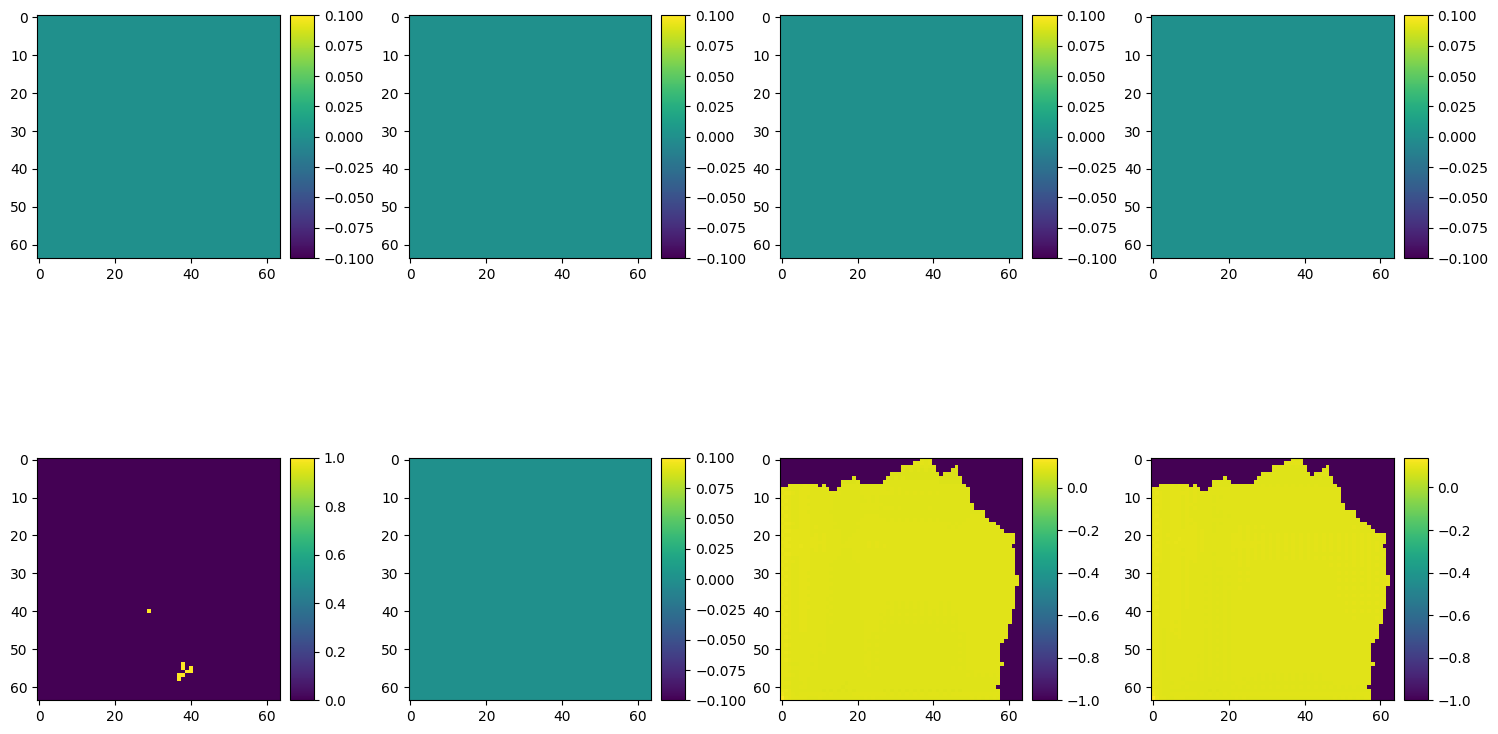

In [25]:
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable

# Pick a random number from the list
index = np.random.choice(def_indexes)
# cont=0
# cont -= -1
# index = def_indexes[cont]
print(index)
patches_pred = preds[index, 1]
patches = test_files[index]

patches_pred[:, mask_test_files[index] == 0] = -1

patches[:, mask_test_files[index] == 0] = -1
patches[patches > 0] = 1
patches[patches < 0] = 0
    
fig, axs = plt.subplots(2, 4, figsize=(15, 10))

patches_plot = np.concatenate((patches, patches_pred), axis=0)
for i in range(2):
    for j in range(4):
        im = axs[i, j].imshow(patches_plot[i*4 + j])
        divider = make_axes_locatable(axs[i, j])
        cax = divider.append_axes("right", size="10%", pad=0.1)
        fig.colorbar(im, cax=cax)
        # axs[i, j].axis('off')

plt.tight_layout()
plt.show()

In [7]:
#apply pred mask
for i in range(preds.shape[0]):
    # preds[i, :, patches_pred[i] == 1] = -1
    # patches_pred = preds[i, 1]
    # print(preds[i].shape)
    preds[i, :, :, mask_test_files[i] == 0] = -1

In [58]:
print(preds.shape)

(79248, 2, 2, 64, 64)


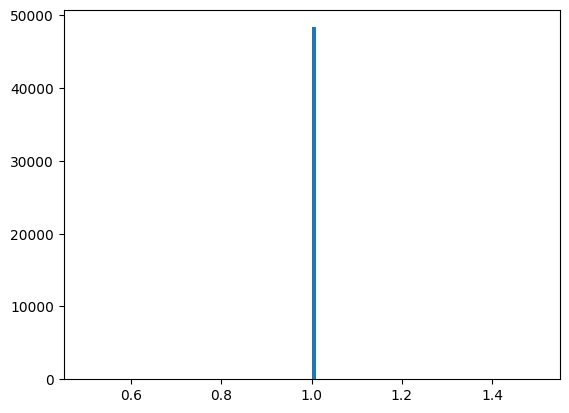

In [9]:
# def_preds = preds[:, 1]
# def_preds = def_preds[def_preds != -1]
test_files2 = test_patches.copy()
test_files2[test_files2 > 0] = 1
test_files2[test_files2 <= 0] = 0
test_files3 = test_files2[test_files2 == 1]
# Plot histogram
plt.hist(test_files3.reshape(-1), bins=100)
plt.show()

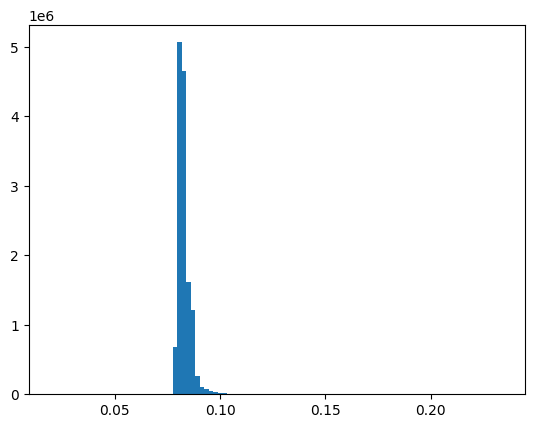

In [8]:
def_preds = preds[:, 1]
def_preds = def_preds[def_preds != -1]

# Plot histogram
plt.hist(def_preds, bins=100)
plt.show()

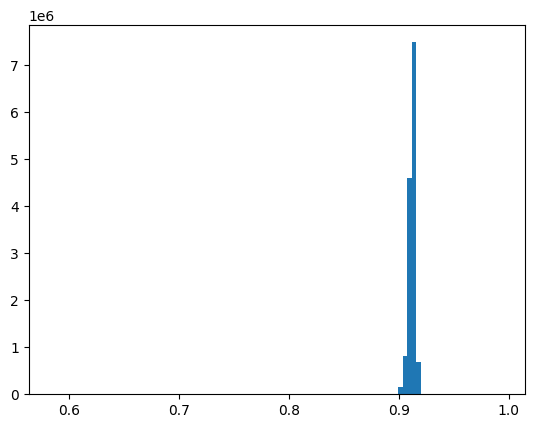

In [62]:
no_def_preds = preds[:, 0]
no_def_preds = no_def_preds[no_def_preds != -1]

# Plot histogram
plt.hist(no_def_preds, bins=100)
plt.show()